Installing Essential Libraries

In [1]:
!pip install transformers
!pip install torch torchvision
!pip install pillow
!pip install faiss-cpu  # Install FAISS for vector search
!pip install huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 44.8 MB/s eta 0:00:00


Import necessary libraries

In [2]:
from transformers import CLIPProcessor, CLIPModel, VisionEncoderDecoderModel, AutoTokenizer
import torch
import faiss
from PIL import Image
import numpy as np
from google.colab import files
import os
import matplotlib.pyplot as plt


Load models for image captioning and embedding generation

In [3]:
# CLIP model for image embeddings
clip_model_name = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(clip_model_name)
clip_processor = CLIPProcessor.from_pretrained(clip_model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [4]:
# Vision-Encoder-Decoder model for image captioning
caption_model_name = "nlpconnect/vit-gpt2-image-captioning"
caption_model = VisionEncoderDecoderModel.from_pretrained(caption_model_name)
caption_tokenizer = AutoTokenizer.from_pretrained(caption_model_name)


config.json:   0%|          | 0.00/4.61k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/982M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/241 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

Function to generate image caption using ViT-GPT2

In [5]:
def generate_image_caption(image_path):
    image = Image.open(image_path).convert("RGB") # convert image into a format suitable for clip input
    pixel_values = clip_processor(images=image, return_tensors="pt").pixel_values # input for caption model woulf be pixelvalues as tensors
    output_ids = caption_model.generate(pixel_values) # output tokens from caption model
    caption = caption_tokenizer.decode(output_ids[0], skip_special_tokens=True) # tokenizer for generating human readable caption
    return caption

Function to generate image embedding using CLIP

In [6]:
def get_image_embedding(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = clip_processor(images=image, return_tensors="pt")
    with torch.no_grad():
        image_embeddings = clip_model.get_image_features(**inputs)
    return image_embeddings.cpu().numpy() # image embeddings with Clip model

Create a FAISS index for storing image embeddings

In [7]:
embedding_size = 512  # CLIP model output size
index = faiss.IndexFlatL2(embedding_size)  # L2 distance index


In [8]:
# Dictionary to keep track of image file names
image_name_dict = {}


Function to upload at least 5 images

In [9]:
def upload_images(min_images=5):
    uploaded = {}
    while len(uploaded) < min_images:
        print(f"Please upload at least {min_images - len(uploaded)} more image(s).")
        new_uploads = files.upload()
        uploaded.update(new_uploads)
    return uploaded

In [10]:
# Upload at least 5 images
uploaded_images = upload_images(min_images=10)

Please upload at least 10 more image(s).


Saving chrisevans.jpeg to chrisevans.jpeg
Saving whale.jpeg to whale.jpeg
Saving catto.jpeg to catto.jpeg
Saving man2.webp to man2.webp
Saving man.jpeg to man.jpeg
Saving gr3.jpeg to gr3.jpeg
Saving chow.jpeg to chow.jpeg
Saving white_cat.jpeg to white_cat.jpeg
Saving elephant.jpeg to elephant.jpeg
Saving duck.jpeg to duck.jpeg
Saving dolphin.jpeg to dolphin.jpeg
Saving chris.jpeg to chris.jpeg
Saving persiancat.jpeg to persiancat.jpeg


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


Image: chrisevans.jpeg
Caption: a man in a suit and tie 



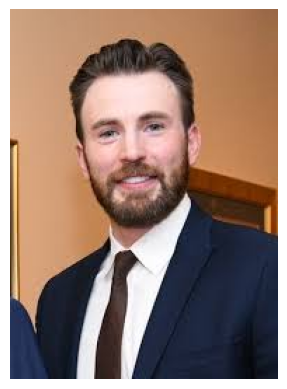

Image: whale.jpeg
Caption: a large white water bottle in the water 



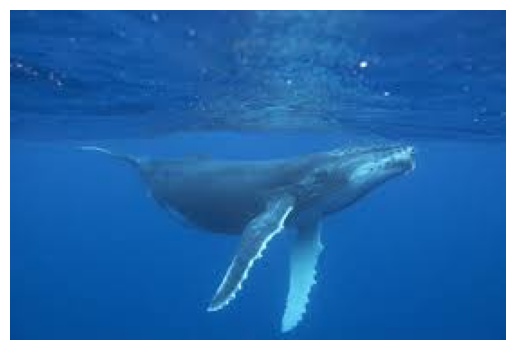

Image: catto.jpeg
Caption: a cat is sitting in a green field 



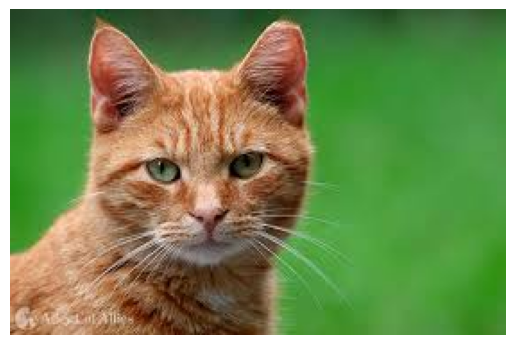

Image: man2.webp
Caption: a man in a suit and tie 



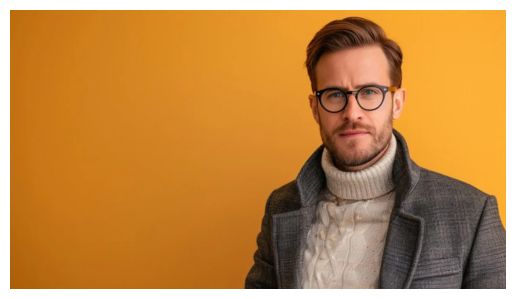

Image: man.jpeg
Caption: a man in a white shirt and tie 



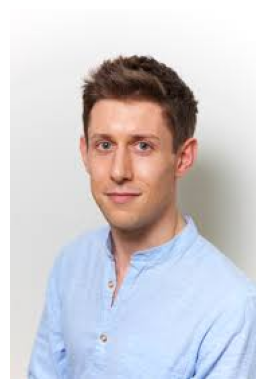

Image: gr3.jpeg
Caption: a dog is standing on a beach 



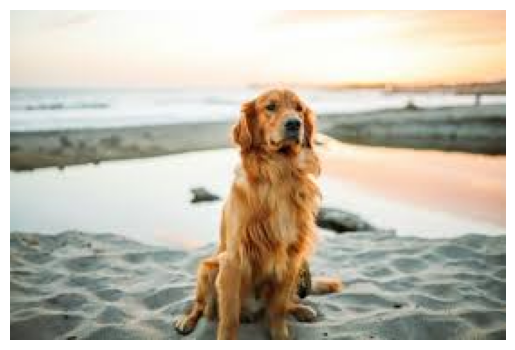

Image: chow.jpeg
Caption: a brown dog standing next to a brown and white dog 



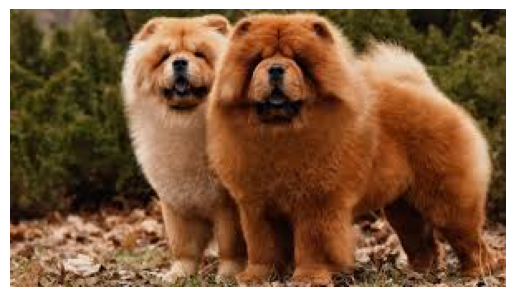

Image: white_cat.jpeg
Caption: a white cat sitting on a wooden floor 



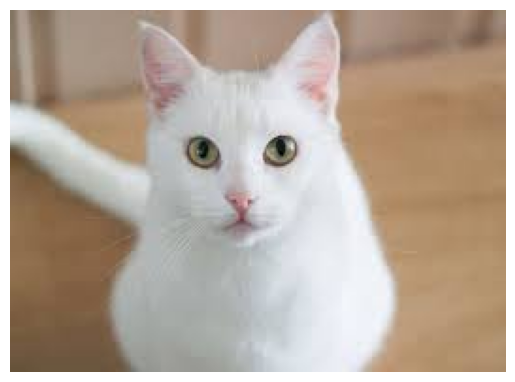

Image: elephant.jpeg
Caption: a large elephant is in the water 



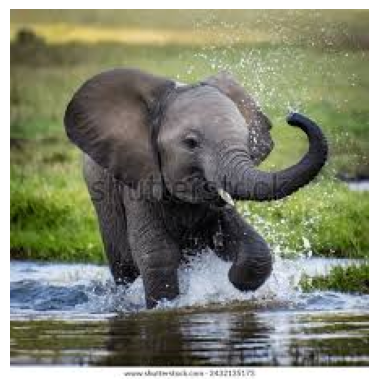

Image: duck.jpeg
Caption: two white ducks standing in a grassy field 



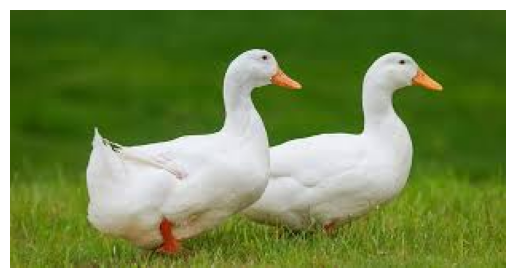

Image: dolphin.jpeg
Caption: a close up picture of a water sports athlete 



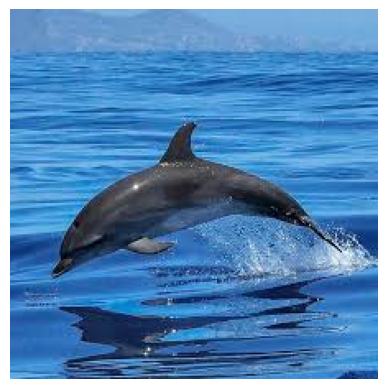

Image: chris.jpeg
Caption: a man is holding a white object in his hand 



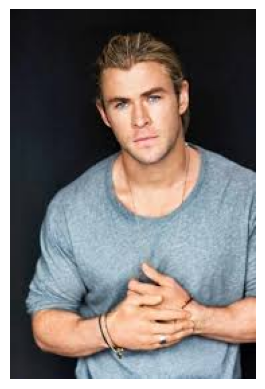

Image: persiancat.jpeg
Caption: a cat sitting on a table looking at the camera 



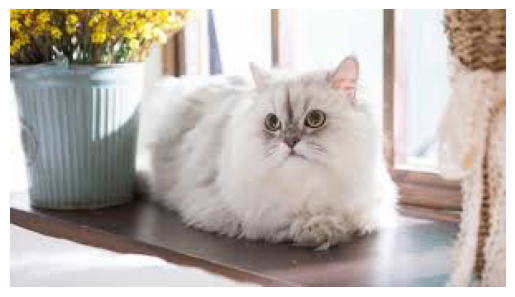

In [11]:
# Process and store image embeddings and captions
for i, image_name in enumerate(uploaded_images.keys()):
    embedding = get_image_embedding(image_name)
    index.add(embedding)
    image_name_dict[i] = image_name
    caption = generate_image_caption(image_name)
    print(f"Image: {image_name}")
    print(f"Caption: {caption}\n")

    # Display uploaded image
    image = Image.open(image_name)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [12]:
print(f"Total images stored in FAISS index: {index.ntotal}")

Total images stored in FAISS index: 13


 Function to find similar images and generate captions

In [13]:
def find_similar_images_and_caption(query_image_path, top_k=5):
    # Generate caption for the query image
    caption = generate_image_caption(query_image_path)
    print(f"Caption for Query Image: {caption}\n")

    # Get the query image embedding
    query_embedding = get_image_embedding(query_image_path)

    # Search for similar images in the FAISS index
    distances, indices = index.search(query_embedding, top_k)

    # Display the query image
    print("Query Image:")
    display(Image.open(query_image_path))

    # Display similar images
    print("\nSimilar Images:")

    for idx in indices[0]:
        # Check if the index is valid (not -1)
        if idx != -1:
            similar_image_name = image_name_dict.get(idx, "Image not found")
            #print(f"Image: {similar_image_name}")
            # similarity_score = distances[0][i]  # Get the corresponding distance

            print(f"Image: {similar_image_name}")
            #print(f"Similarity Score (Distance): {similarity_score}\n")



            try:
                display(Image.open(similar_image_name))
            except FileNotFoundError:
                print(f"File {similar_image_name} not found.")
        else:
            print("No similar images found for this query.")

Function to provide options for next steps

In [14]:
def next_step():
    print("\nChoose an option:")
    print("1: Generate image caption for a new image")
    print("2: Find similar images for a new image")
    print("3: Exit")
    choice = input("Enter the option number: ")
    return choice

Function to handle user choice

In [15]:
def handle_choice(choice):
    if choice == '1':
        query_image = files.upload()
        query_image_path = list(query_image.keys())[0]
        caption = generate_image_caption(query_image_path)
        print(f"Caption for uploaded image: {caption}")

    elif choice == '2':
        query_image = files.upload()
        query_image_path = list(query_image.keys())[0]
        find_similar_images_and_caption(query_image_path, top_k=5)

    elif choice == '3':
        print("Exiting...")
        return False

    else:
        print("Invalid choice. Please try again.")
    return True

Main loop to handle user interaction


Choose an option:
1: Generate image caption for a new image
2: Find similar images for a new image
3: Exit
Enter the option number: 2


Saving cat.jpeg to cat.jpeg
Caption for Query Image: a cat sitting on a chair 

Query Image:


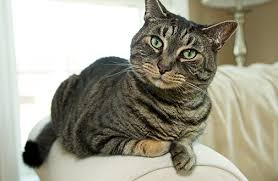


Similar Images:
Image: white_cat.jpeg


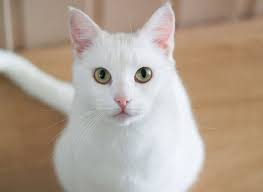

Image: catto.jpeg


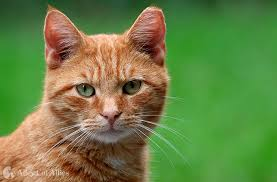

Image: persiancat.jpeg


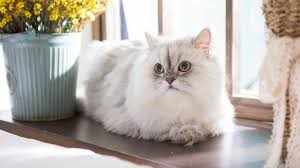

Image: gr3.jpeg


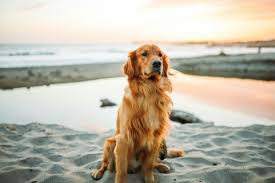

Image: chow.jpeg


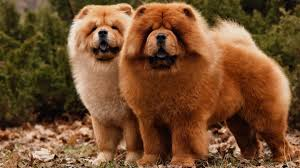


Choose an option:
1: Generate image caption for a new image
2: Find similar images for a new image
3: Exit
Enter the option number: 2


Saving gs_dog.jpeg to gs_dog.jpeg
Caption for Query Image: a dog standing on the beach looking at the water 

Query Image:


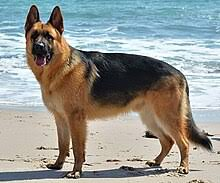


Similar Images:
Image: gr3.jpeg


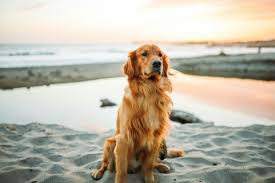

Image: chow.jpeg


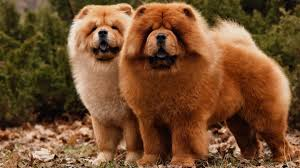

Image: catto.jpeg


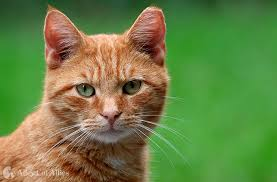

Image: white_cat.jpeg


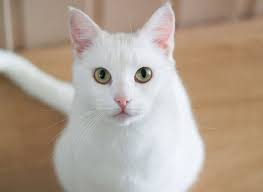

Image: dolphin.jpeg


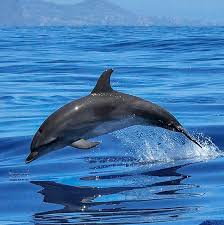


Choose an option:
1: Generate image caption for a new image
2: Find similar images for a new image
3: Exit
Enter the option number: 2


Saving gr1_dog.jpeg to gr1_dog.jpeg
Caption for Query Image: a dog is laying down on the ground 

Query Image:


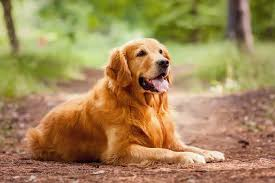


Similar Images:
Image: gr3.jpeg


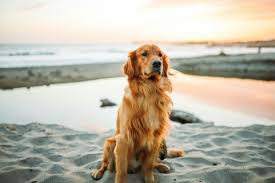

Image: chow.jpeg


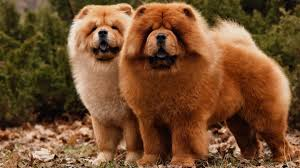

Image: persiancat.jpeg


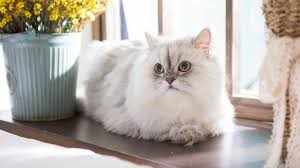

Image: catto.jpeg


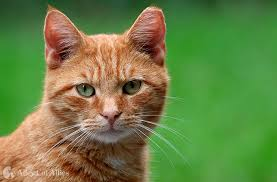

Image: white_cat.jpeg


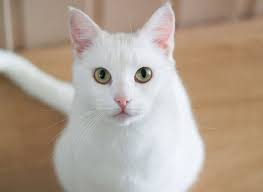


Choose an option:
1: Generate image caption for a new image
2: Find similar images for a new image
3: Exit
Enter the option number: 3
Exiting...


In [16]:
continue_interaction = True

while continue_interaction:
    choice = next_step()
    continue_interaction = handle_choice(choice)